# Задание 1

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   147M      0  0:00:05  0:00:05 --:--:--  167M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import zipfile
import random
from shutil import copyfile

In [ ]:
import pathlib
data_dir = pathlib.Path("PetImages")

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Удаляем испорченные и не поддерживаемые изображения
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
image_size = (150, 150)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

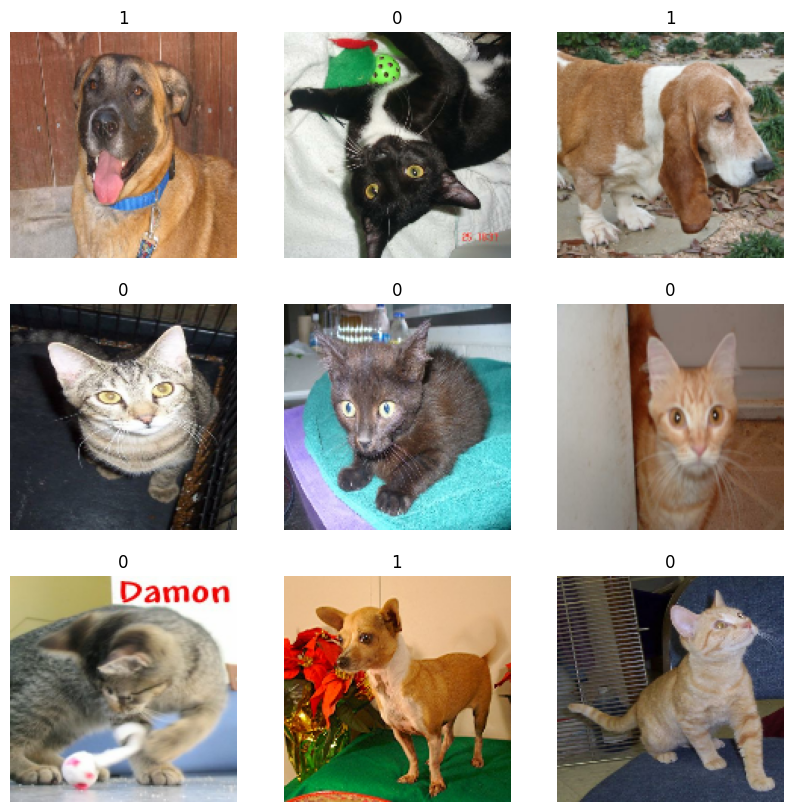

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255, input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

Epoch 1/10
1171/1171 [==============================] - 33s 28ms/step - loss: 0.4392 - accuracy: 0.8047 - val_loss: 0.4306 - val_accuracy: 0.8067
Epoch 2/10
1171/1171 [==============================] - 32s 27ms/step - loss: 0.4255 - accuracy: 0.8095 - val_loss: 0.4252 - val_accuracy: 0.8161
Epoch 3/10
1171/1171 [==============================] - 33s 28ms/step - loss: 0.4188 - accuracy: 0.8163 - val_loss: 0.4285 - val_accuracy: 0.8150
Epoch 4/10
1171/1171 [==============================] - 31s 26ms/step - loss: 0.4130 - accuracy: 0.8169 - val_loss: 0.4735 - val_accuracy: 0.7817
Epoch 5/10
1171/1171 [==============================] - 32s 27ms/step - loss: 0.4121 - accuracy: 0.8224 - val_loss: 0.5308 - val_accuracy: 0.7947
Epoch 6/10
1171/1171 [==============================] - 31s 26ms/step - loss: 0.4070 - accuracy: 0.8240 - val_loss: 0.4350 - val_accuracy: 0.7992
Epoch 7/10
1171/1171 [==============================] - 33s 28ms/step - loss: 0.4052 - accuracy: 0.8213 - val_loss: 0.3867 -

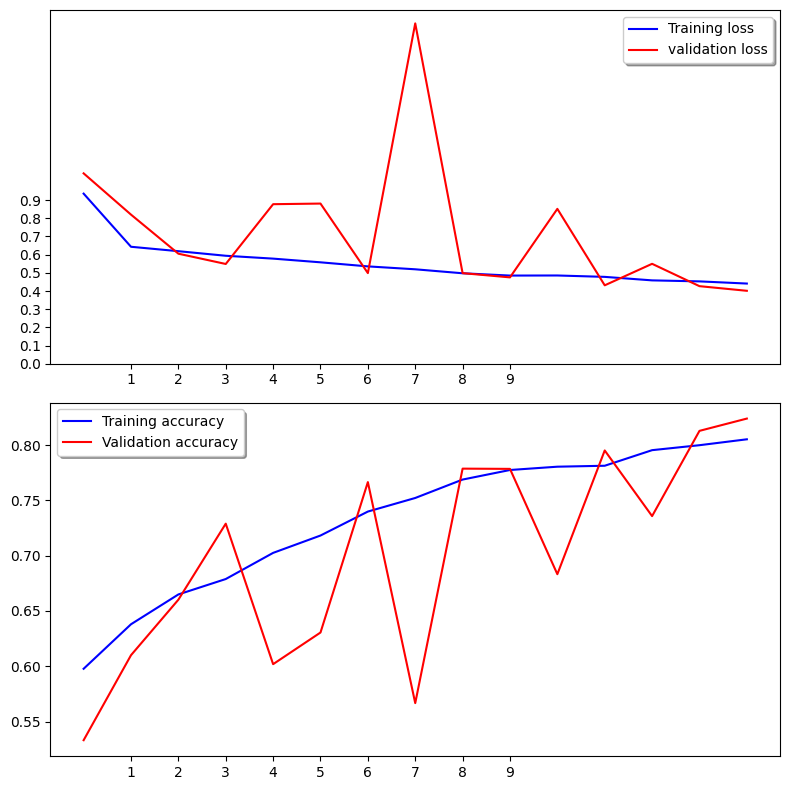

In [ ]:
def learning_curves(history, epochs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))
    legend1 = ax1.legend(loc='best', shadow=True)

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend2 = ax2.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

learning_curves(history, 10)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

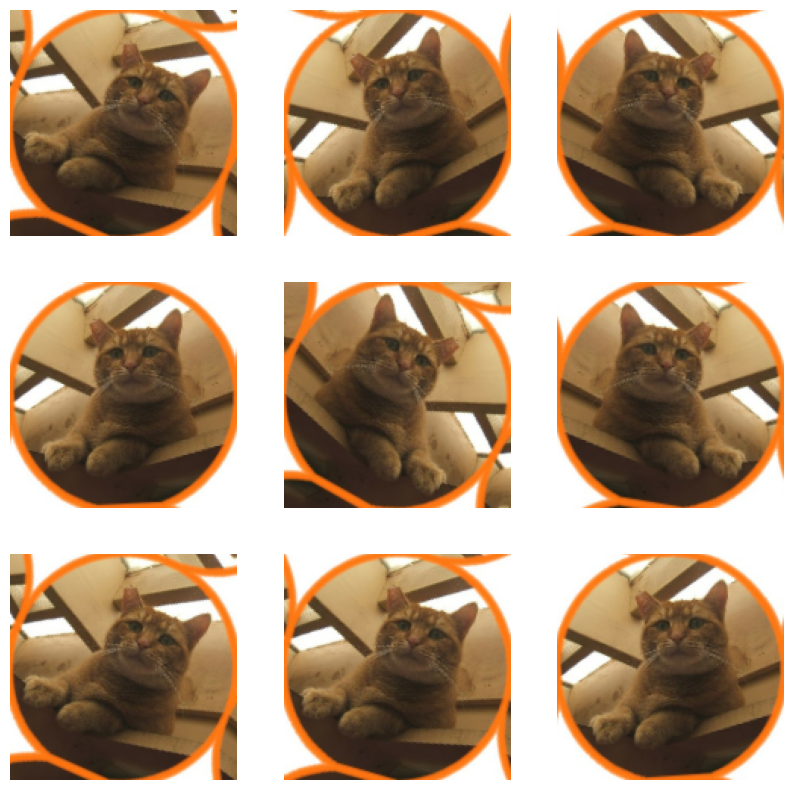

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                 

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

Epoch 1/10
1171/1171 [==============================] - 34s 27ms/step - loss: 0.6427 - accuracy: 0.6302 - val_loss: 0.5729 - val_accuracy: 0.6978
Epoch 2/10
1171/1171 [==============================] - 30s 26ms/step - loss: 0.5420 - accuracy: 0.7242 - val_loss: 0.4717 - val_accuracy: 0.7695
Epoch 3/10
1171/1171 [==============================] - 31s 27ms/step - loss: 0.4880 - accuracy: 0.7661 - val_loss: 0.4247 - val_accuracy: 0.8061
Epoch 4/10
1171/1171 [==============================] - 31s 26ms/step - loss: 0.4530 - accuracy: 0.7882 - val_loss: 0.3898 - val_accuracy: 0.8283
Epoch 5/10
1171/1171 [==============================] - 36s 31ms/step - loss: 0.4240 - accuracy: 0.8039 - val_loss: 0.4118 - val_accuracy: 0.8234
Epoch 6/10
1171/1171 [==============================] - 31s 27ms/step - loss: 0.4012 - accuracy: 0.8185 - val_loss: 0.3549 - val_accuracy: 0.8481
Epoch 7/10
1171/1171 [==============================] - 30s 26ms/step - loss: 0.3789 - accuracy: 0.8318 - val_loss: 0.3522 -

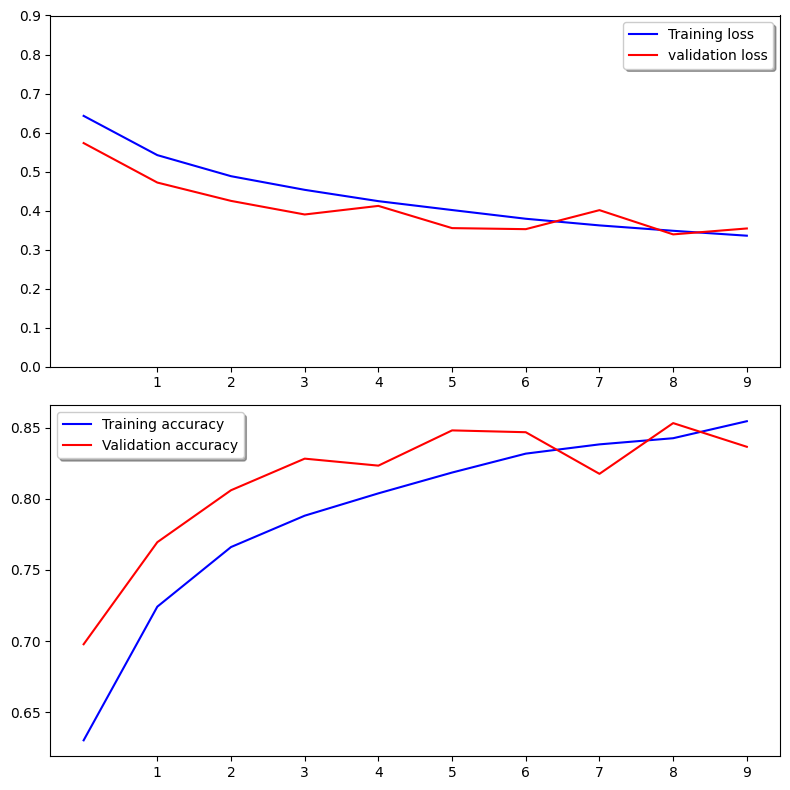

In [ ]:
learning_curves(history, 10)

## Попытка улучшить модель

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)       

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, verbose=1)

Epoch 1/15
1171/1171 [==============================] - 39s 28ms/step - loss: 0.9356 - accuracy: 0.5977 - val_loss: 1.0471 - val_accuracy: 0.5331
Epoch 2/15
1171/1171 [==============================] - 32s 27ms/step - loss: 0.6434 - accuracy: 0.6380 - val_loss: 0.8202 - val_accuracy: 0.6100
Epoch 3/15
1171/1171 [==============================] - 32s 27ms/step - loss: 0.6191 - accuracy: 0.6649 - val_loss: 0.6054 - val_accuracy: 0.6602
Epoch 4/15
1171/1171 [==============================] - 35s 29ms/step - loss: 0.5940 - accuracy: 0.6789 - val_loss: 0.5488 - val_accuracy: 0.7290
Epoch 5/15
1171/1171 [==============================] - 32s 27ms/step - loss: 0.5782 - accuracy: 0.7025 - val_loss: 0.8776 - val_accuracy: 0.6019
Epoch 6/15
1171/1171 [==============================] - 32s 27ms/step - loss: 0.5579 - accuracy: 0.7182 - val_loss: 0.8810 - val_accuracy: 0.6305
Epoch 7/15
1171/1171 [==============================] - 31s 26ms/step - loss: 0.5356 - accuracy: 0.7399 - val_loss: 0.4987 -

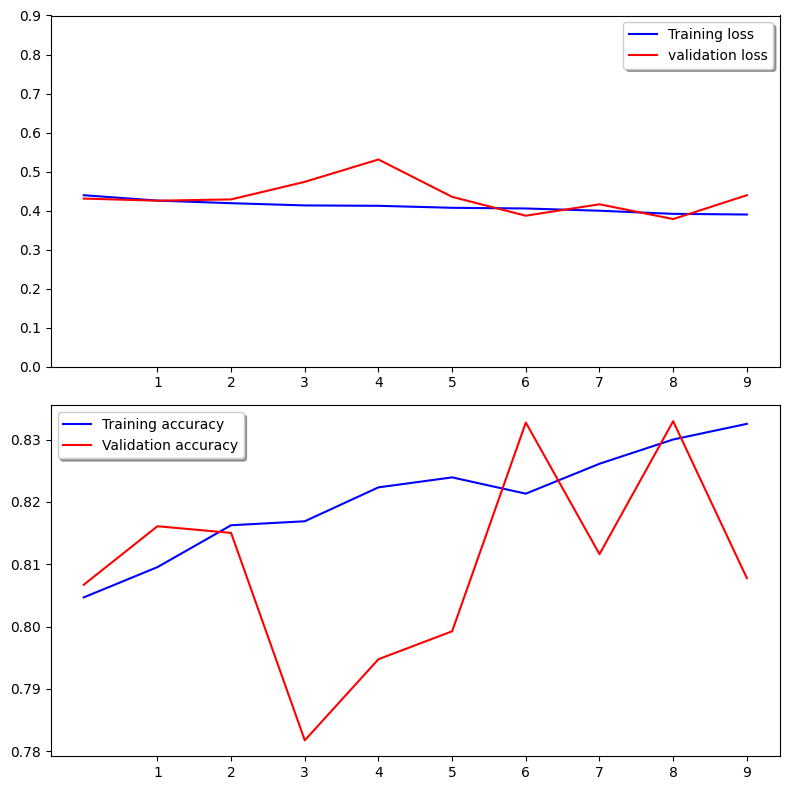

In [18]:
learning_curves(history, 10)

# Задание 2

In [ ]:
data_dir = pathlib.Path("horsehuman")

In [ ]:
image_size = (300, 300)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1200 files belonging to 2 classes.
Using 960 files for training.
Found 1200 files belonging to 2 classes.
Using 240 files for validation.


In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

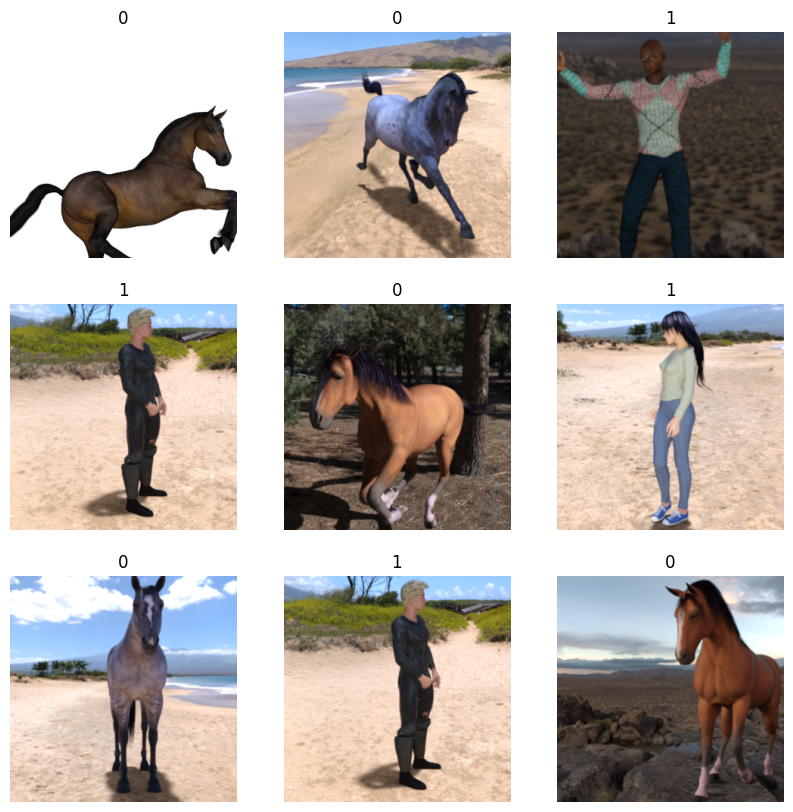

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255, input_shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 149, 149, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 71, 71, 64)       

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

Epoch 1/10
60/60 [==============================] - 10s 115ms/step - loss: 0.8707 - accuracy: 0.8281 - val_loss: 0.1445 - val_accuracy: 0.9708
Epoch 2/10
60/60 [==============================] - 6s 86ms/step - loss: 0.1240 - accuracy: 0.9667 - val_loss: 0.0953 - val_accuracy: 0.9667
Epoch 3/10
60/60 [==============================] - 6s 91ms/step - loss: 0.0420 - accuracy: 0.9917 - val_loss: 0.0638 - val_accuracy: 0.9750
Epoch 4/10
60/60 [==============================] - 5s 75ms/step - loss: 0.0204 - accuracy: 0.9969 - val_loss: 0.0493 - val_accuracy: 0.9875
Epoch 5/10
60/60 [==============================] - 6s 95ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9917
Epoch 6/10
60/60 [==============================] - 6s 87ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9958
Epoch 7/10
60/60 [==============================] - 5s 74ms/step - loss: 1.8859e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9875
Epoch 8

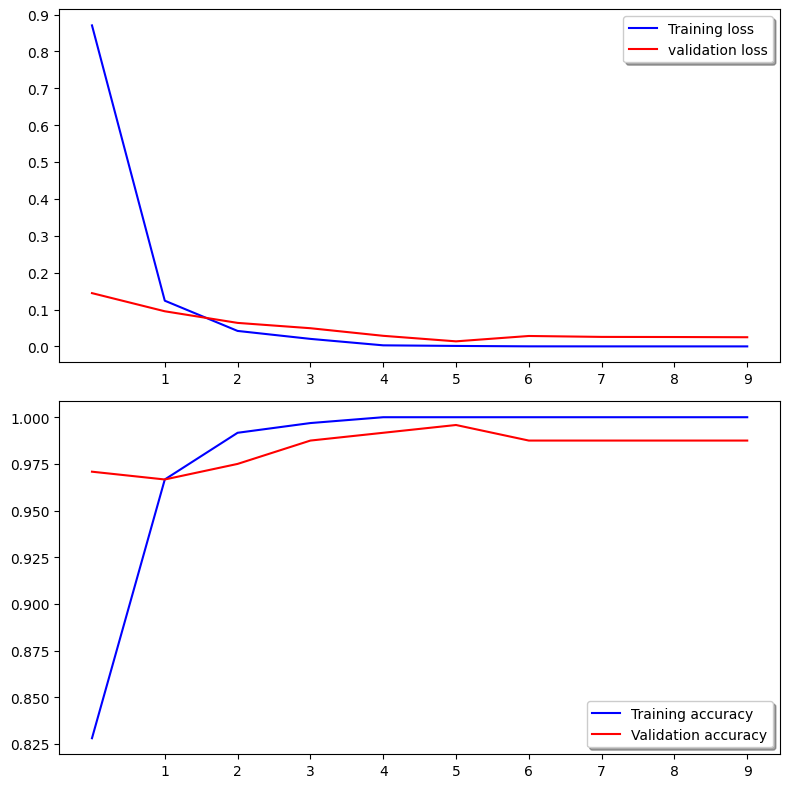

In [ ]:
learning_curves(history, 10)